In [58]:
%pwd

'/Users/sebbyzhao/Research/RecSys/recsys'

In [10]:
import torch
import os
import seaborn as sns
import implicit
import pandas as pd
from scipy import sparse
from numpy.linalg import svd
import numpy as np

/Users/sebbyzhao/Library/Caches/pypoetry/virtualenvs/recsys-lkkaVlXU-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
DATA_DIR = '../data/ml-100k/'

In [66]:
training_data = pd.read_csv(os.path.join(DATA_DIR, 'ua.base'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
training_data.head()

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [67]:
test_data = pd.read_csv(os.path.join(DATA_DIR, 'ua.test'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
test_data.head()

,user_id,item_id,rating,timestamp
0,1,20,4,887431883
1,1,33,4,878542699
2,1,61,4,878542420
3,1,117,3,874965739
4,1,155,2,878542201


In [95]:
test_rating_matrix = pd.pivot_table(test_data, index='user_id', columns='item_id', values='rating', fill_value=0)
test_rating_matrix.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1591,1592,1600,1612,1617,1646,1653,1656,1662,1664
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
test_rating_array = test_rating_matrix.values > 3

In [73]:
rating_matrix = pd.pivot_table(training_data, values='rating', index='user_id', columns='item_id', fill_value=0)
rating_matrix.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5,3,4,3,3,5,4,1,5,3,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
rating_proxy = rating_matrix.copy().applymap(lambda x: 1 if x > 0 else 0)
rating_proxy.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
rating_proxy_array = rating_proxy.values

In [76]:
from typing import Union

In [128]:
class ALSModel():
    def __init__(self, r, alpha=40, lmbda=50 , num_recommendations=10, num_factors=100):
        self.lmbda = lmbda
        self.users, self.items = r.shape
        # Confidence matrix
        self.c = 1 + alpha * r

        # Preference matrix
        self.p = r

        # User latent factor matrix
        self.x = np.random.rand(self.users, num_factors).astype(np.float32) * .01

        # Item latent factor matrix
        self.y = np.random.rand(self.items, num_factors).astype(np.float32) * .01

        self.num_recommendations = num_recommendations



    def least_squares_step(self, X, Y, optimize=Union['user', 'item']):
        if optimize == 'user':
            YtY = Y.T @ Y
            for i in range(X.shape[0]):
                Cu = np.diag(self.c[i])
                A = YtY + Y.T @ (Cu - np.identity(Y.shape[0])) @ Y + self.lmbda * np.identity(Y.shape[1])
                b = Y.T @ Cu @ self.p[i]
                X[i] = np.linalg.solve(A, b)
        elif optimize == 'item':
            XtX = X.T @ X
            for j in range(Y.shape[0]):
                Ci = np.diag(self.c[:, j])
                A = XtX + X.T @ (Ci - np.identity(X.shape[0])) @ X + self.lmbda * np.identity(X.shape[1])
                b = X.T @ Ci @ self.p[:, j]
                Y[j] = np.linalg.solve(A, b)
        
    def loss(self):
        # Calculate loss to make sure it's decreasing.
        total = 0

        item_scores = self.x @ self.y.T
        confidence_weighted = self.c * (self.p - item_scores) ** 2
        total += np.sum(confidence_weighted)
        total += self.lmbda * (np.sum(self.x ** 2) + np.sum(self.y ** 2))

        return total / (self.x.shape[0] * self.y.shape[0])


    def backward(self):
        # Update user latent factor matrix
            
        self.least_squares_step(self.x, self.y, optimize='user')
        self.least_squares_step(self.x, self.y, optimize='item')

    def forward(self, X):
        return X @ self.y.T


In [129]:
def apk(recommendations, true_prefs, true_prefs_rating):
    """
    recommendations: List[Int] = list of recommendations of items by index suggested
    true_prefs: List[Int] = list of ground truth items user likes
    """
    count = 0
    count_rating = 0
    total = 0
    total_rating = 0

    for i in range(len(recommendations)):
        seen = i + 1
        recommendation = recommendations[i]
        if recommendation in true_prefs:
            count += 1
            total += count / seen
        if recommendation in true_prefs_rating:
            count_rating += 1
            total_rating += count_rating / seen

    apk_proxy = 1 / min(len(recommendations), len(true_prefs)) * total if len(true_prefs) > 0 else 0
    apk_true = 1 / min(len(recommendations), len(true_prefs_rating)) * total_rating if len(true_prefs_rating) > 0 else 0
    
    return apk_proxy, apk_true

def validation(training_data, test_data, model, k=10):
    """
    """
    # Get top k recommendations for each user
    item_scores = model.x @ model.y.T

    apks = []
    true_apks = []
    for i in range(len(item_scores)):
        user_id = i + 1
        user_scores = item_scores[i]
        previously_scored = training_data[training_data['user_id'] == user_id]['item_id'].values - 1

        all_items = np.arange(0, len(user_scores))
        user_scores[np.isin(all_items, previously_scored)] = -np.inf

        # True prefs proxy
        true_prefs = test_data[test_data['user_id'] == user_id]['item_id'].values - 1

        # True prefs rating

        # Get all items rated above 3
        true_prefs_rating = test_rating_array[i, :] 
        # Convert to item indexes
        true_prefs_rating = np.where(true_prefs_rating)[0]

        # Sort and calculate metric
        top_indexes = np.argsort(user_scores)[::-1]

        proxy_apk, true_apk = apk(top_indexes[:10], true_prefs, true_prefs_rating)
        apks.append(proxy_apk)
        true_apks.append(true_apk)

    return np.mean(apks), np.mean(true_apks)
    

def train(model,num_epochs=10):
    training_losses = []
    proxy_losses = []
    true_losses = []
    for i in range(num_epochs):
        print("===\nEpoch: ", i)
        model.backward()

        loss = model.loss()
        print("Training Error: ", loss)
        training_losses.append(loss)

        proxy_loss, true_loss = validation(training_data, test_data, model)
        print("Validation Proxy MAP@K: ", proxy_loss)
        proxy_losses.append(proxy_loss)

        print("Validation True MAP@K: ", true_loss)
        true_losses.append(true_loss)


    return model, training_losses, proxy_losses, true_losses


In [130]:
model = ALSModel(rating_proxy_array)

In [131]:
model, training_losses, proxy_losses, true_losses = train(model, 100)

===
Epoch:  0
Training Error:  0.9385453692981001
Validation Proxy MAP@K:  0.10759514551667256
Validation True MAP@K:  0.015703081603797405
===
Epoch:  1
Training Error:  0.30827471885695396
Validation Proxy MAP@K:  0.11879147098924404
Validation True MAP@K:  0.014742093216061807
===
Epoch:  2
Training Error:  0.25477400700040265
Validation Proxy MAP@K:  0.1169970879833022
Validation True MAP@K:  0.013882755057955784
===
Epoch:  3
Training Error:  0.2410100659226097
Validation Proxy MAP@K:  0.11803123264151896
Validation True MAP@K:  0.014280439611923478
===
Epoch:  4
Training Error:  0.23436625917864157
Validation Proxy MAP@K:  0.11971102863202546
Validation True MAP@K:  0.014330130121645294
===
Epoch:  5
Training Error:  0.23056018665256892
Validation Proxy MAP@K:  0.12003896715985793
Validation True MAP@K:  0.014183917773935698
===
Epoch:  6
Training Error:  0.22818435473066803
Validation Proxy MAP@K:  0.12052100691814371
Validation True MAP@K:  0.01377372509429521
===
Epoch:  7
Tra

In [132]:
training_losses, proxy_losses, true_losses 

([0.9385453692981001,
  0.30827471885695396,
  0.25477400700040265,
  0.2410100659226097,
  0.23436625917864157,
  0.23056018665256892,
  0.22818435473066803,
  0.2266153737456271,
  0.22553423708030002,
  0.22476313822985255,
  0.22419717950493182,
  0.22377159829734003,
  0.22344483427120235,
  0.22318932911347192,
  0.2229862275181938,
  0.22282239789659986,
  0.22268845212435665,
  0.22257754514528777,
  0.2224846839151346,
  0.2224061025905471,
  0.22233898170743335,
  0.22228114463102183,
  0.22223094515662853,
  0.22218707497585943,
  0.22214851764777147,
  0.22211444670533628,
  0.2220842195532779,
  0.22205731758748462,
  0.2220332842512831,
  0.22201174837214507,
  0.22199244173031385,
  0.22197505691756964,
  0.2219593730309447,
  0.2219452278455124,
  0.22193242092919643,
  0.2219208107887865,
  0.22191028750313865,
  0.22190070689127855,
  0.22189198614135855,
  0.2218840157899667,
  0.22187672893723034,
  0.22187003171302966,
  0.2218638944637826,
  0.2218582429041444,
  

In [139]:
data = np.hstack([np.array(training_losses).reshape(-1, 1), np.array(proxy_losses).reshape(-1, 1), np.array(true_losses).reshape(-1, 1)])
data = pd.DataFrame(data)
data = data.rename(mapper={0: 'Training Loss', 1: 'Validation Proxy MAP@K', 2: 'Validation True MAP@K'}, axis=1)
data

,Training Loss,Validation Proxy MAP@K,Validation True MAP@K
0,0.938545,0.107595,0.015703
1,0.308275,0.118791,0.014742
2,0.254774,0.116997,0.013883
3,0.241010,0.118031,0.014280
4,0.234366,0.119711,0.014330
...,...,...,...
95,0.221764,0.121545,0.013387
96,0.221764,0.121633,0.013453
97,0.221763,0.121747,0.013456
98,0.221763,0.121617,0.013443


<Axes: >

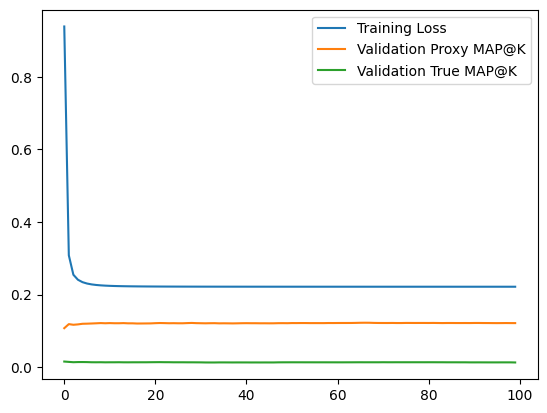

In [140]:
sns.lineplot(data=data, dashes=False)

<Axes: >

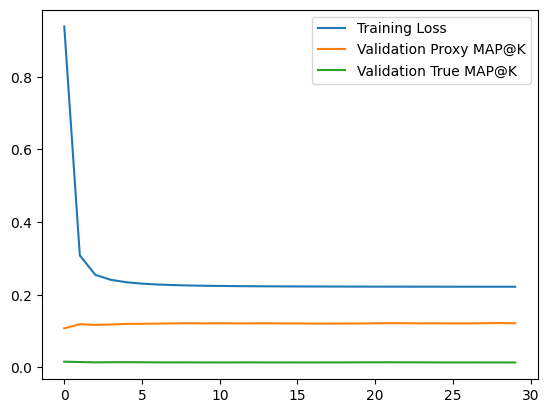

In [142]:
sns.lineplot(data=data.iloc[:30], dashes=False)

<Axes: >

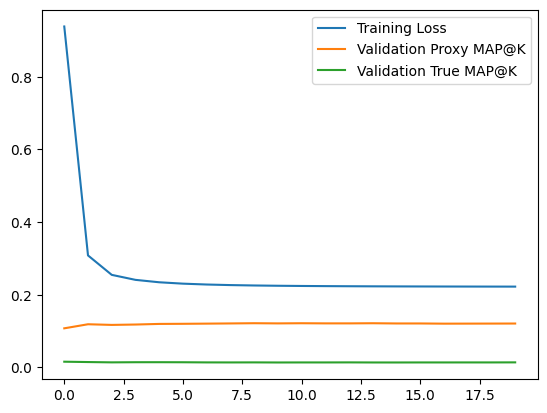

In [143]:
sns.lineplot(data=data.iloc[:20], dashes=False)

<Axes: ylabel='Validation Proxy MAP@K'>

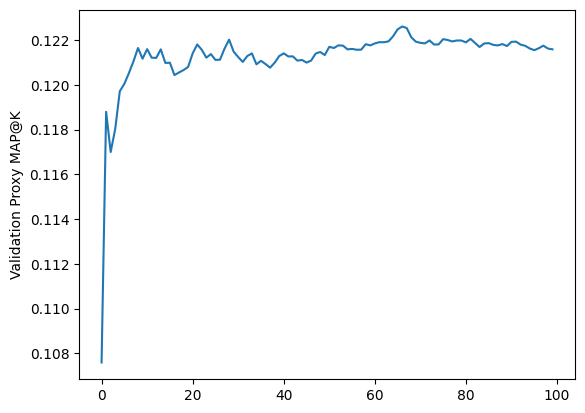

In [147]:
sns.lineplot(data=data['Validation Proxy MAP@K'].iloc[:100], dashes=False)

<Axes: ylabel='Validation True MAP@K'>

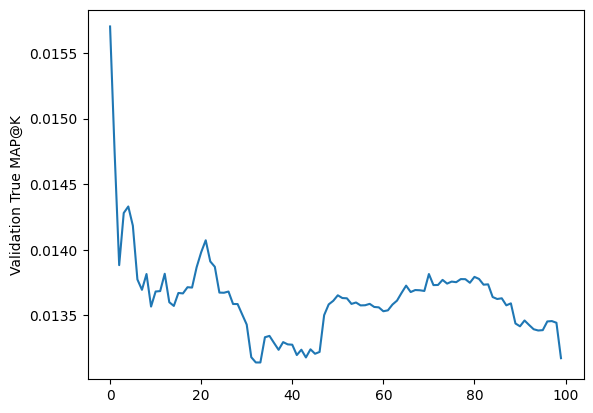

In [146]:
sns.lineplot(data=data['Validation True MAP@K'].iloc[:100], dashes=False)

In [136]:
a = pd.read_csv(os.path.join(DATA_DIR, 'ua.base'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp']).head()

In [137]:
b = pd.read_csv(os.path.join(DATA_DIR, 'ua.test'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp']).head()

In [ ]:
# In order to determine a validation set, 

In [146]:
# Calculate mapK by making predictions on everything excluding training dataset?